# 은행거래 사기


## 준비

In [1]:
!pip install -U sagemaker

     |████████████████████████████████| 406 kB 22.0 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.33.0-py2.py3-none-any.whl size=571508 sha256=f6b8974f89b5ca3c53c8745fca8e6050b6ce1f8471167e73933823bc92d523a0
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7b/7b/8e/513ae4c2b3ec1c04917d0aab34d1083c27534723cceaec085f
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.31.1
    Uninstalling sagemaker-2.31.1:
      Successfully uninstalled sagemaker-2.31.1


In [4]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = 'change to your s3 bucket name'  # replace with an existing bucket if needed
file = 'banking_fraud.csv'
prefix = 'sagemaker/'           # prefix used for all data stored within the bucket

data_location = 's3://{}/{}'.format(bucket, file) 

# Define IAM role
import boto3
from sagemaker import get_execution_role

role = get_execution_role()

In [5]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.serializers import CSVSerializer
from sklearn.preprocessing import MinMaxScaler

## 데이터

In [6]:
df = pd.read_csv(data_location)

In [7]:
df.shape

(3000, 9)

In [8]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,CASH_OUT,140421.18,C1667570766,16004.0,0.00,C2102410298,0.00,140421.18,0
1,CASH_OUT,216666.53,C1495945377,50398.0,0.00,C814408370,10119297.16,10335963.70,0
2,CASH_OUT,234636.20,C269129885,74262.0,0.00,C1389815469,166046.48,400682.68,0
3,CASH_IN,52816.29,C129678616,117751.0,170567.29,C842027837,0.00,0.00,0
4,CASH_OUT,63871.25,C1282823885,6012.0,0.00,C1236511065,456488.36,520359.60,0


In [9]:
df['isFraud'].mean() 

0.112

## 탐험


In [11]:
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=['object']).columns:
    print(column, len(df[column].unique()))

type 5
nameOrig 3000
nameDest 2999


In [12]:
column = 'type'
display(pd.crosstab(index=df[column], columns='% observations', normalize='columns'))

col_0,% observations
type,
CASH_IN,0.144667
CASH_OUT,0.311667
DEBIT,0.017000
PAYMENT,0.414667
TRANSFER,0.112000


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3000.000000
mean,2.542131e+05,3.209679e+05,1.460443e+05,6.789421e+05,8.044602e+05,0.112000
std,1.072189e+06,2.255314e+06,1.592268e+06,3.156094e+06,3.243301e+06,0.315419
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,7.515708e+03,1.035475e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,3.297213e+04,3.058350e+04,4.176675e+03,0.000000e+00,0.000000e+00,0.000000
75%,1.522532e+05,9.948825e+04,6.888302e+04,2.255525e+05,3.795359e+05,0.000000
max,1.000000e+07,5.731626e+07,4.731626e+07,1.053767e+08,1.052426e+08,1.000000


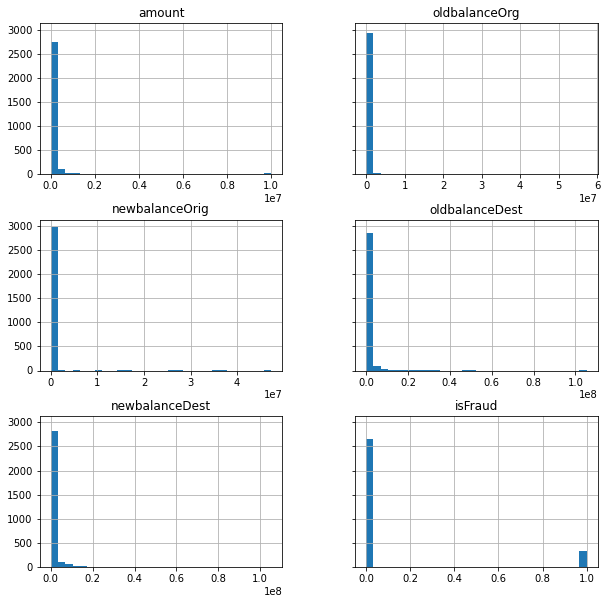

In [13]:

display(df.describe())
%matplotlib inline
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

In [14]:
y_column = 'isFraud'
x_column = 'type'
display(pd.crosstab(index=df[x_column], columns=df[y_column], normalize='columns'))

isFraud,0,1
type,,
CASH_IN,0.162913,0.0
CASH_OUT,0.287913,0.5
DEBIT,0.019144,0.0
PAYMENT,0.466967,0.0
TRANSFER,0.063063,0.5


amount


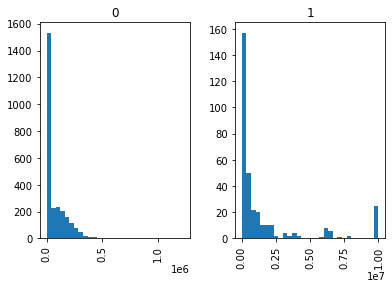

oldbalanceOrg


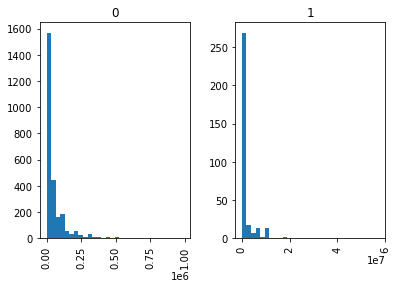

newbalanceOrig


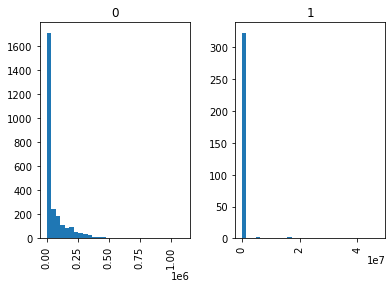

oldbalanceDest


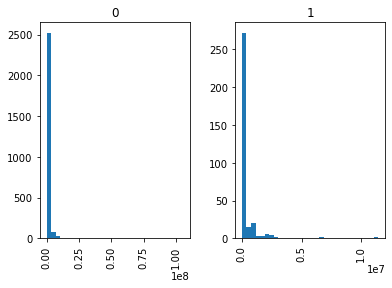

newbalanceDest


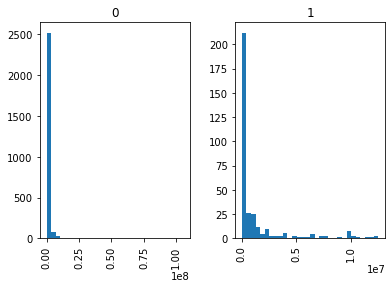

isFraud


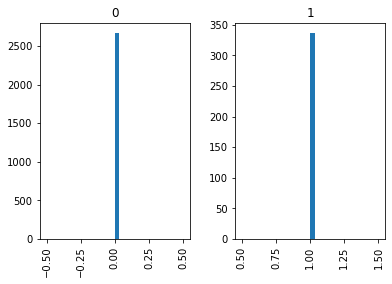

In [15]:
for column in df.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = df[column].hist(by=df[y_column], bins=30)
    plt.show()

In [16]:
display(df.corr())

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,0.793612,0.485213,-0.010605,0.147020,0.465154
oldbalanceOrg,0.793612,1.000000,0.906651,-0.018543,0.054395,0.324129
newbalanceOrig,0.485213,0.906651,1.000000,-0.009689,-0.013352,0.143456
oldbalanceDest,-0.010605,-0.018543,-0.009689,1.000000,0.972684,-0.026609
newbalanceDest,0.147020,0.054395,-0.013352,0.972684,1.000000,0.047420
isFraud,0.465154,0.324129,0.143456,-0.026609,0.047420,1.000000


## Feature Engineering


In [17]:
one_hot = pd.get_dummies(df['type'])
one_hot.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0


In [19]:
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
scaler = MinMaxScaler()
transformed_data = scaler.fit_transform(df[numeric_features])

In [20]:
transformed_data

array([[1.40421180e-02, 2.79222709e-04, 0.00000000e+00, 0.00000000e+00,
        1.33426150e-03],
       [2.16666530e-02, 8.79296806e-04, 0.00000000e+00, 9.60297766e-02,
        9.82108144e-02],
       [2.34636200e-02, 1.29565339e-03, 0.00000000e+00, 1.57574248e-03,
        3.80722819e-03],
       ...,
       [6.31140928e-01, 1.10115521e-01, 0.00000000e+00, 6.49943163e-04,
        6.06208582e-02],
       [8.50002520e-02, 1.48300429e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [8.50002520e-02, 1.48300429e-02, 0.00000000e+00, 6.17793265e-02,
        6.99346086e-02]])

In [21]:
transformed_df = pd.DataFrame(transformed_data)
transformed_df

,0,1,2,3,4
0,0.014042,0.000279,0.000000,0.000000,0.001334
1,0.021667,0.000879,0.000000,0.096030,0.098211
2,0.023464,0.001296,0.000000,0.001576,0.003807
3,0.005282,0.002054,0.003605,0.000000,0.000000
4,0.006387,0.000105,0.000000,0.004332,0.004944
...,...,...,...,...,...
2995,0.033968,0.005926,0.000000,0.000000,0.003228
2996,0.631141,0.110116,0.000000,0.000000,0.000000
2997,0.631141,0.110116,0.000000,0.000650,0.060621
2998,0.085000,0.014830,0.000000,0.000000,0.000000


In [22]:
final_df = pd.concat([df, one_hot, transformed_df], axis = 1)

In [23]:

final_df.shape

(3000, 19)

In [24]:
final_df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,0,1,2,3,4
0,CASH_OUT,140421.18,C1667570766,16004.0,0.00,C2102410298,0.00,140421.18,0,0,1,0,0,0,0.014042,0.000279,0.000000,0.000000,0.001334
1,CASH_OUT,216666.53,C1495945377,50398.0,0.00,C814408370,10119297.16,10335963.70,0,0,1,0,0,0,0.021667,0.000879,0.000000,0.096030,0.098211
2,CASH_OUT,234636.20,C269129885,74262.0,0.00,C1389815469,166046.48,400682.68,0,0,1,0,0,0,0.023464,0.001296,0.000000,0.001576,0.003807
3,CASH_IN,52816.29,C129678616,117751.0,170567.29,C842027837,0.00,0.00,0,1,0,0,0,0,0.005282,0.002054,0.003605,0.000000,0.000000
4,CASH_OUT,63871.25,C1282823885,6012.0,0.00,C1236511065,456488.36,520359.60,0,0,1,0,0,0,0.006387,0.000105,0.000000,0.004332,0.004944


In [25]:
columns_to_drop = ['type', 'isFraud', 'nameOrig', 'nameDest']

In [26]:

train_data, validation_data, test_data = np.split(final_df.sample(frac=1, random_state=2021), [int(0.7 * len(final_df)), int(0.9 * len(final_df))])

In [27]:

pd.concat([train_data['isFraud'], train_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('train.csv', index=False, header=False)


In [28]:
pd.concat([validation_data['isFraud'], validation_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)


In [29]:
pd.concat([test_data['isFraud'], test_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('test.csv', index=False, header=False)


In [30]:
pd.concat([test_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('test_features.csv', index=False, header=False)


In [31]:

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test_features.csv')).upload_file('test.csv')


## 학습


In [32]:

from sagemaker import image_uris
container = sagemaker.image_uris.retrieve(framework = 'xgboost', region = boto3.Session().region_name, version = 'latest')

In [33]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [34]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=10)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2021-04-06 07:05:31 Starting - Starting the training job...
2021-04-06 07:05:57 Starting - Launching requested ML instancesProfilerReport-1617692731: InProgress
......
2021-04-06 07:06:57 Starting - Preparing the instances for training.........
2021-04-06 07:08:17 Downloading - Downloading input data...
2021-04-06 07:09:00 Training - Training image download completed. Training in progress.
2021-04-06 07:09:00 Uploading - Uploading generated training model.Arguments: train
[2021-04-06:07:08:55:INFO] Running standalone xgboost training.
[2021-04-06:07:08:55:INFO] File size need to be processed in the node: 0.31mb. Available memory size in the node: 8421.33mb
[2021-04-06:07:08:55:INFO] Determined delimiter of CSV input is ','
[07:08:55] S3DistributionType set as FullyReplicated
[07:08:55] 2100x15 matrix with 31500 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-04-06:07:08:55:INFO] Determined delimiter of CSV input is ','
[07:08:55] S3DistributionT

## 호스팅

In [37]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

---------------!

## 평가

In [38]:
xgb_predictor.serializer = CSVSerializer()

In [39]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for i, array in enumerate(split_array):
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
        if i % 100 == 0:
            print(i, 'out of', len(split_array), 'completed')
    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(columns_to_drop, axis=1).to_numpy())


0 out of 1 completed


In [40]:
pd.crosstab(index=test_data['isFraud'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])


predictions,0.0,1.0
actuals,,
0,261,4
1,3,32


## (옵션) 리소스 제거


In [35]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
